In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import os
import seaborn as sns

# création dataset

In [2]:
df = pd.read_csv('../data/metadata.csv').replace(np.nan,'')

In [3]:
df['sat_image_path_2'] ='../data/'+ df['sat_image_path']

In [4]:
df.head()

,image_id,split,sat_image_path,mask_path,sat_image_path_2
0,100694,train,train/100694_sat.jpg,train/100694_mask.png,../data/train/100694_sat.jpg
1,102122,train,train/102122_sat.jpg,train/102122_mask.png,../data/train/102122_sat.jpg
2,10233,train,train/10233_sat.jpg,train/10233_mask.png,../data/train/10233_sat.jpg
3,103665,train,train/103665_sat.jpg,train/103665_mask.png,../data/train/103665_sat.jpg
4,103730,train,train/103730_sat.jpg,train/103730_mask.png,../data/train/103730_sat.jpg


In [5]:
max_idx_train = int(len(df[df.split=='train'])*.8)
max_idx_train

642

In [6]:
df_train = df[df.split=='train'][:max_idx_train]
df_test = df[df.split=='train'][max_idx_train:]

In [7]:
ds_paths_train = tf.data.Dataset.from_tensor_slices(df_train.sat_image_path_2)
ds_paths_test = tf.data.Dataset.from_tensor_slices(df_test.sat_image_path_2)

Metal device set to: Apple M1 Pro


2022-11-30 12:44:33.693800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 12:44:33.693949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    return img

def get_corresponding_mask(path):
    path_mask = tf.strings.regex_replace(path,'sat.jpg','mask.png')
    mask = load_image(path_mask)
    return mask 

def load_data(path):
    img = load_image(path)
    try:
        mask = get_corresponding_mask(path)
    except FileNotFoundError:
        mask = None
    return img,mask

In [9]:
labels_df = pd.read_csv('../data/class_dict.csv')
labels = {i:[s['r'],s['g'],s['b']] for i,s in labels_df.iterrows()}

labels

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [10]:
#enconding classes colors

z = np.array([[[0, 255, 255],
[255, 255, 0],
[255, 0, 255],
[0, 255, 0],
[0, 0, 255],
[255, 255, 255],
[0, 0, 0]]])

(z/255).dot([[2**0],[2**1],[2**2]])

array([[[6.],
        [3.],
        [5.],
        [2.],
        [4.],
        [7.],
        [0.]]])

In [247]:
def encoder(img,mask=None):
    mask = mask/255
    tensor = tf.tensordot(tf.cast(mask,tf.int32),tf.constant([[2**0],[2**1],[2**2]]),axes=1)

    return img,tensor

## Count classes

In [248]:
# def counter(img,mask=None):
#     mask = tf.reshape(mask,shape=[-1])
#     return tf.unique_with_counts(mask)

# from tqdm.notebook import tqdm

# counts = np.zeros(shape=(8))

# for elem in tqdm(ds.map(encoder).map(counter).as_numpy_iterator()):
#     counts[elem[0]]+=elem[2]

# sns.barplot(x=np.arange(0,8),y=counts)

# pd.DataFrame((counts/counts.sum())*100)

# 2448*2448*803 == counts.sum()

# Resize images

In [244]:
2448//224

10

In [245]:
2448/224

10.928571428571429

In [246]:
224*11

2464

In [249]:
def resizer(img,mask=None,n_samples=11,img_height=2448,img_width=2448,img_channels=3):

    tile_height = 224 
    tile_width = 224
    
#     n_samples = img_height//tile_height
    
    img_pad = tf.image.pad_to_bounding_box(img,0,0,224*n_samples,224*n_samples)
    mask_pad = tf.image.pad_to_bounding_box(mask,0,0,224*n_samples,224*n_samples)
    
    
    
    img = tf.reshape(img_pad,(n_samples,tile_height,n_samples,tile_width,img_channels))
    img = tf.transpose(img,(0,2,1,3,4))
    img = tf.reshape(img,(-1,tile_height,tile_width,img_channels))
    
    mask = tf.reshape(mask_pad,(n_samples,tile_height,n_samples,tile_width,img_channels))
    mask = tf.transpose(mask,(0,2,1,3,4))
    mask = tf.reshape(mask,(-1,tile_height,tile_width,img_channels))
    
    return img,mask

# Rescale images

In [250]:
def rescaler (img,mask):
    scaler = tf.keras.layers.Rescaling(1./255)
    return scaler(img),mask

# Binary task with forest class

In [85]:
def binary_mask(img,mask):
    shape = tf.shape(mask)
    np_fun = lambda x: np.where(x==2,1,0)
    mask_bin = tf.numpy_function(func=np_fun,inp=[mask],Tout=tf.int64)
    mask_bin = tf.reshape(mask_bin,shape)
#     mask_bin = tf.squeeze(mask_bin)
#     mask_bin=tf.cast(tf.equal(mask,[3]),tf.uint8)
#     indexes = tf.where(tf.equal(mask, 3))
#     mask_bin = tf.gather_nd(mask, indexes)
    return img,mask_bin

In [260]:
ds_binary_train = ds_paths_train.map(load_data).map(rescaler).map(resizer).map(encoder).map(binary_mask).unbatch()#.batch(4)
ds_binary_test = ds_paths_test.map(load_data).map(rescaler).map(resizer).map(encoder).map(binary_mask).unbatch()#.batch(4)

# MODELS

## non trained model

In [88]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self,NumFilter:int,BatchNorm:bool,DropOut:float):

        self.batch_norm = BatchNorm
        
        self.conv2D = tf.keras.layers.Conv2D(filters=NumFilter, kernel_size=(3,3), strides=(1,1), padding='same')
#         self.conv2Dbis = tf.keras.layers.Conv2D(filters=NumFilter, kernel_size=(3,3), strides=(1,1), padding='same')
        self.activ = tf.keras.layers.Activation('relu')
        self.norm_layer = tf.keras.layers.BatchNormalization()
        self.drop = tf.keras.layers.Dropout(DropOut)
        self.pool = tf.keras.layers.MaxPooling2D((2,2))
        
        super(EncoderBlock,self).__init__()
        
    def call(self,inputs):
        x = self.conv2D(inputs)
#         x = self.conv2Dbis(x)
        res = self.activ(x)
        if self.batch_norm:
            res = self.norm_layer(x)
        x = self.pool(res)
        output = self.drop(x)
        
        return output,res



In [89]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,NumFilter:int,BatchNorm:bool,DropOut:float):

        self.batch_norm = BatchNorm
        
        self.conv2D = tf.keras.layers.Conv2D(NumFilter, kernel_size=(3,3), strides=(1,1), padding='same')
#         self.conv2Dbis = tf.keras.layers.Conv2D(NumFilter, kernel_size=(3,3), strides=(1,1), padding='same')
        self.activ = tf.keras.layers.Activation('relu')
        self.norm_layer = tf.keras.layers.BatchNormalization()
        self.drop = tf.keras.layers.Dropout(DropOut)
        self.upsampling = tf.keras.layers.UpSampling2D((2,2))
        self.concat = tf.keras.layers.Concatenate()
        
        super(DecoderBlock,self).__init__()
        
    def call(self,inputs,residuals):
        x = self.upsampling(inputs)
        x = self.concat([x,residuals])
        x = self.conv2D(x)
#         x = self.conv2Dbis(x)
        x = self.activ(x)
        if self.batch_norm:
            x = self.norm_layer(x)
        output = self.drop(x)
        
        return output


In [90]:
class BottleneckBloc(tf.keras.layers.Layer):
    def __init__(self,NumFilter:int,BatchNorm:bool,DropOut:float):
        self.batch_norm = BatchNorm
        
        self.conv2D = tf.keras.layers.Conv2D(NumFilter, kernel_size=(3,3), strides=(1,1), padding='same')
#         self.conv2Dbis = tf.keras.layers.Conv2D(NumFilter, kernel_size=(3,3), strides=(1,1), padding='same')
        self.activ = tf.keras.layers.Activation('relu')
        self.norm_layer = tf.keras.layers.BatchNormalization()
        self.drop = tf.keras.layers.Dropout(DropOut)
        
        super(BottleneckBloc,self).__init__()
        
    def call(self,inputs):
        x = self.conv2D(inputs)
#         x = self.conv2Dbis(x)
        x = self.activ(x)
        
        if self.batch_norm:
            x = self.norm_layer(x)
        
        output = self.drop(x)
        
        return output
        

In [91]:
#create model
def drawmeaunet():
    inputs = tf.keras.layers.Input((224,224,3))
    c1,res1 = EncoderBlock(64,True,.2,)(inputs)
    c2,res2 = EncoderBlock(128,True,.2,)(c1)
    c3,res3 = EncoderBlock(256,True,.2,)(c2)
    c4,res4 = EncoderBlock(512,True,.2,)(c3)

    bottleneck = BottleneckBloc(512,True,.2,)(c4)

    d4 = DecoderBlock(512,True,.2)(bottleneck,res4)
    d3 = DecoderBlock(256,True,.2)(d4,res3)
    d2 = DecoderBlock(128,True,.2)(d3,res2)
    d1 = DecoderBlock(64,True,.2)(d2,res1)

    output = tf.keras.layers.Conv2D(1,kernel_size=1,strides=1,activation='sigmoid')(d1)
    unet = tf.keras.Model(inputs=inputs,outputs=output)
    return unet

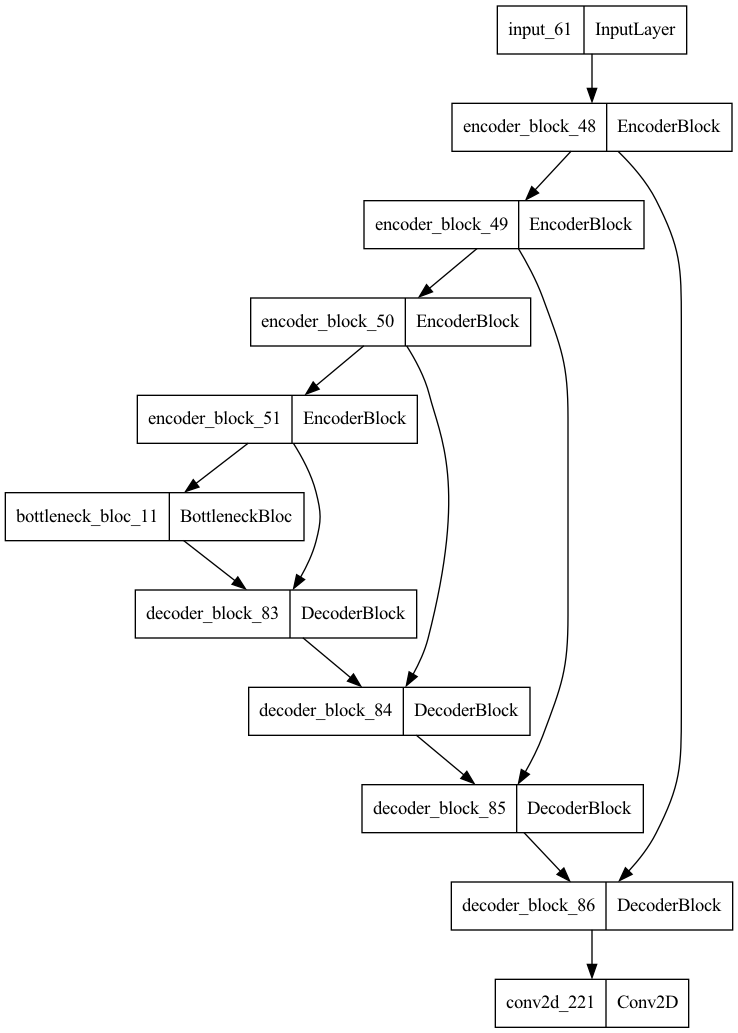

In [240]:
unet = drawmeaunet()
tf.keras.utils.plot_model(unet)

### trainer

In [92]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=0.5):
        super(DiceLoss, self).__init__()
        # self.threshold = tf.constant([threshold])

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        # y_pred = tf.cast(tf.math.greater(y_pred,self.threshold),dtype=tf.int64) #TODO idem a éclaircir
        numerator = 2 * tf.reduce_sum(y_true * y_pred) + 1
        denominator = (
            tf.reduce_sum(y_true + y_pred) + 1
        )  # to avoid cases where denom == 0
        return 1 - numerator / denominator

In [93]:
loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.25, gamma=2)
# loss = DiceLoss()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
iou_score = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0,1])
recall = tf.keras.metrics.Recall(name="recall")
precision = tf.keras.metrics.Precision(name="precision")

In [94]:
es = tf.keras.callbacks.EarlyStopping(patience=2)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor=.5,patience=1,mode='auto')

In [123]:
unet = drawmeaunet()
unet.compile(optimizer=optimizer, loss=loss)#, metrics=[precision, recall])

In [136]:
ds_train = ds_binary_train.batch(2).prefetch(4)
ds_test = ds_binary_test.batch(2).prefetch(4)

In [ ]:
next(ds_train.take(1)

In [125]:
# ds_train.save('gs://dataset_arthur')

In [126]:
history = unet.fit(ds_train,epochs=10)#,callbacks=[es],validation_data=ds_test)

Epoch 1/10


2022-11-30 13:05:43.256733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  13/9711 [..............................] - ETA: 1:39:22 - loss: 0.2764

KeyboardInterrupt: 

In [241]:
next(iter(ds_train.take(1)))

(<tf.Tensor: shape=(8, 224, 224, 3), dtype=float32, numpy=
 array([[[[0.49411768, 0.427451  , 0.30980393],
          [0.49803925, 0.43137258, 0.3137255 ],
          [0.48627454, 0.41960788, 0.3019608 ],
          ...,
          [0.53333336, 0.454902  , 0.3254902 ],
          [0.53333336, 0.454902  , 0.3254902 ],
          [0.54901963, 0.47058827, 0.34117648]],
 
         [[0.4901961 , 0.42352945, 0.30588236],
          [0.48627454, 0.41960788, 0.3019608 ],
          [0.48235297, 0.4156863 , 0.29803923],
          ...,
          [0.5176471 , 0.43921572, 0.30980393],
          [0.5294118 , 0.45098042, 0.32156864],
          [0.5647059 , 0.48627454, 0.35686275]],
 
         [[0.48235297, 0.4156863 , 0.29803923],
          [0.48235297, 0.4156863 , 0.29803923],
          [0.4901961 , 0.42352945, 0.30588236],
          ...,
          [0.5529412 , 0.47450984, 0.34509805],
          [0.5254902 , 0.44705886, 0.31764707],
          [0.5176471 , 0.43921572, 0.30980393]],
 
         ...,
 
       

In [253]:
def dummy():
    inputs = tf.keras.layers.Input((224,224,3))
    outputs = tf.keras.layers.Lambda(lambda x : x)(inputs)
#     c1,res1 = EncoderBlock(64,True,.2,)(inputs)
    
#     d1 = DecoderBlock(64,True,.2)(c1,res1)
#     output = tf.keras.layers.Conv2D(1,kernel_size=1,strides=1,activation='sigmoid')(d1)
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    return model

In [254]:
dummy = dummy()

In [261]:
ds_dummy = ds_binary_train.batch(8).prefetch(4)

In [262]:
dummy.compile(optimizer=optimizer, loss=loss,)
dummy.fit(ds_dummy,epochs=10,callbacks=[es],validation_data=ds_test)

Epoch 1/10


2022-11-30 17:51:40.046593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3833/9711 [==========>...................] - ETA: 46s - loss: 0.5766

KeyboardInterrupt: 

## pretrained model

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=False,pooling='None')
tf.keras.utils.plot_model(vgg,show_shapes=True,show_layer_names=True)

In [ ]:
def create_vgg_backbone():
    vgg = tf.keras.applications.vgg16.VGG16(include_top=False,pooling='None',input_shape=(224,224,3))
    layer_names = ['block1_conv2','block2_conv2','block3_conv3','block4_conv3','block5_conv3']
    layers_residuals = [vgg.get_layer(name).output for name in layer_names]
    backbone = tf.keras.Model(inputs=vgg.input, outputs=layers_residuals)
    backbone.trainable = False
    return backbone

In [160]:
create_vgg_backbone().outputs#[-1]#.shape

[<KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'block4_conv3')>,
 <KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'block5_conv3')>]

In [ ]:
d4 = DecoderBlock(512,True,.2)(bottleneck,res4)
d3 = DecoderBlock(256,True,.2)(d4,res3)
d2 = DecoderBlock(128,True,.2)(d3,res2)
d1 = DecoderBlock(64,True,.2)(d2,res1)

In [202]:
def drawmeapretrainedunet():
    inputs = tf.keras.layers.Input((224,224,3))
    
    backbone = create_vgg_backbone()
    skips = backbone(inputs)
    
    x = skips[-2]
    skips = reversed(skips[:-2])
    
#     d4 = DecoderBlock(512,True,.2)
    d3 = DecoderBlock(256,True,.2)
    d2 = DecoderBlock(128,True,.2)
    d1 = DecoderBlock(64,True,.2)
    
    decoders = [d3,d2,d1]
    
    for d, res in zip(decoders, skips):
        x = d(x,res)
        
        
    outputs = tf.keras.layers.Conv2D(1,kernel_size=1,strides=1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    return model

In [203]:
unet = drawmeapretrainedunet()

In [ ]:
tf.keras.utils.plot_model(unet,show_shapes=True,show_layer_names=True)

### trainer

In [205]:
# loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.25, gamma=2)
# loss = DiceLoss()
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
iou_score = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0,1])
recall = tf.keras.metrics.Recall(name="recall")
precision = tf.keras.metrics.Precision(name="precision")

In [206]:
es = tf.keras.callbacks.EarlyStopping(patience=2)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor=.5,patience=1,mode='auto')

In [207]:
unetpretrained = drawmeapretrainedunet()
unetpretrained.compile(optimizer=optimizer, loss=loss)#, metrics=[precision, recall])

In [208]:
ds_train = ds_binary_train.batch(8).prefetch(4)
ds_test = ds_binary_test.batch(8).prefetch(4)

In [209]:
history = unetpretrained.fit(ds_train,epochs=10,callbacks=[es],validation_data=ds_test)

Epoch 1/10


2022-11-30 15:41:26.423038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  89/9711 [..............................] - ETA: 1:11:49 - loss: 0.7299

KeyboardInterrupt: 

## MobileNetV2

In [211]:
def create_mobilenet_backbone():
    mobilenet = tf.keras.applications.MobileNetV2(include_top=False,pooling='None',input_shape=(224,224,3))
    layer_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    layers_residuals = [mobilenet.get_layer(name).output for name in layer_names]
    backbone = tf.keras.Model(inputs=mobilenet.input, outputs=layers_residuals)
    backbone.trainable = False
    return backbone

In [214]:
tf.keras.applications.MobileNetV2(include_top=False,pooling='None',input_shape=(224,224,3)).summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_56[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [215]:
def unet_mobilenet():
    backbone = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu",
                             "block_6_expand_relu","block_13_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = tf.keras.Model(inputs=)
    
    return 

In [229]:
def unet_mobilenet():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_image")
    
    encoder = tf.keras.applications.MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    
    encoder.trainable=False
    
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, x_skip])
        
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
    x = tf.keras.layers.Conv2D(1, (1, 1), padding="same")(x)
    x = tf.keras.layers.Activation("sigmoid")(x)
    
    model = tf.keras.Model(inputs, x)
    return model

In [230]:
unetmobile = unet_mobilenet()

In [231]:
# loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.25, gamma=2)
# loss = DiceLoss()
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
iou_score = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0,1])
recall = tf.keras.metrics.Recall(name="recall")
precision = tf.keras.metrics.Precision(name="precision")

In [232]:
es = tf.keras.callbacks.EarlyStopping(patience=2)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor=.5,patience=1,mode='auto')

In [233]:
unetpretrained = drawmeapretrainedunet()
unetpretrained.compile(optimizer=optimizer, loss=loss)#, metrics=[precision, recall])

In [235]:
ds_train = ds_binary_train.batch(8).prefetch(4)
ds_test = ds_binary_test.batch(8).prefetch(4)

In [236]:
unetmobile = unet_mobilenet()
unetmobile.compile(optimizer=optimizer, loss=loss)#, metrics=[precision, recall])

In [237]:
history = unetmobile.fit(ds_train,epochs=10,callbacks=[es],validation_data=ds_test)

Epoch 1/10


2022-11-30 16:18:47.784365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4674/9711 [=============>................] - ETA: 17:02 - loss: 0.3215

KeyboardInterrupt: 

In [239]:
tf.image.pad_to_bounding_box()

<function tensorflow.python.ops.image_ops_impl.pad_to_bounding_box(image, offset_height, offset_width, target_height, target_width)>

In [ ]:
tf.keras.layers.UpSampling2D()

In [205]:
# loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.25, gamma=2)
# loss = DiceLoss()
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
iou_score = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0,1])
recall = tf.keras.metrics.Recall(name="recall")
precision = tf.keras.metrics.Precision(name="precision")

In [206]:
es = tf.keras.callbacks.EarlyStopping(patience=2)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor=.5,patience=1,mode='auto')

In [207]:
unetpretrained = drawmeapretrainedunet()
unetpretrained.compile(optimizer=optimizer, loss=loss)#, metrics=[precision, recall])

In [208]:
ds_train = ds_binary_train.batch(8).prefetch(4)
ds_test = ds_binary_test.batch(8).prefetch(4)

In [209]:
history = unetpretrained.fit(ds_train,epochs=10,callbacks=[es],validation_data=ds_test)

Epoch 1/10


2022-11-30 15:41:26.423038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  89/9711 [..............................] - ETA: 1:11:49 - loss: 0.7299

KeyboardInterrupt: 